_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: Aleksejs Timcenko, Ali Gholamzadeh

# Coding Lab 5



In [498]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io
from scipy import stats
import time

%matplotlib inline

plt.style.use("../matplotlib_style.txt")

## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 

*Grading: 2 pts (calculations) + 3 pts (implementation)*


### Calculations
_You can add your calculations in_ $\LaTeX$ _here_.

$L(\omega) = \sum_t \left ( c_t log(r_t) - log(c_t!) - r_t \right ) = \sum_t \left ( c_t \cdot (\omega^Ts_t + log(\Delta t \cdot R)) - log(c_t!) - exp(\omega^T s_t) \cdot \Delta t \cdot R \right )$

$\frac{dL(\omega)}{d\omega} = \sum_t c_t s_{t} - s_t exp(\omega^T s_t) \cdot \Delta t \cdot R  = \sum_t s_t (c_t - r_t)$,

where $s_t$ is a vector of stimulus and $c_t$ and $r_t$ are constants in a given time frame $t$.

### Generate data

Text(0.5, 1.0, 'Gaussian RF')

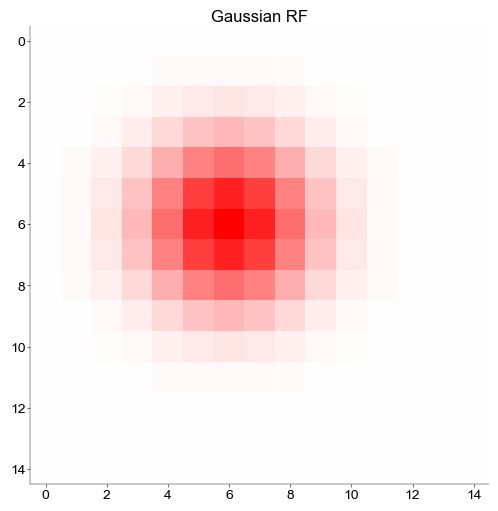

In [386]:
def gen_gauss_rf(D, width, center=(0,0)):
    
    sz = (D-1)/2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(- (x ** 2/width + y ** 2 / width))
    w = w / np.sum(w.flatten())
    
    return w

w = gen_gauss_rf(15,7,(1,1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(w, cmap='bwr', vmin=-vlim, vmax=vlim)
ax.set_title('Gaussian RF')

In [522]:
def sample_lnp(w, nT, dt, R, v):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    v: float
        variance of the stimulus

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    #np.random.seed(10)

    # insert your code here
    
    
    # 1. generate stimulus as uncorrelated checkerboard noise
    # stim = stats.norm(scale=np.sqrt(v)).rvs(size=(stim_size, nT))
    stim = stats.bernoulli(p=0.5).rvs(size=(len(w), nT)) * np.sqrt(v)
    
    # 2. get poisson rate parameter in a given time bin
    rate = (np.exp(w[np.newaxis, :] @ stim) * R * dt).flatten()
    
    # 3. sample poisson spike counts in a bin
    # the function will generate one sample for each rate in the vector rate
    counts = stats.poisson(mu=rate).rvs()

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (0.5 pts)
    # ------------------------------------------------
    
    return counts, rate, stim

In [504]:
D = 15     # number of pixels
nT = 10  # number of time bins
dt = 0.1   # bins of 100 ms
R = 50     # firing rate in Hz 
v = 5      # stimulus variance

w = gen_gauss_rf(D,7,(1,1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, v)

In [514]:
w.size

225

In [517]:
c

array([16, 19, 20, 19, 22, 15, 12, 13, 15,  7])

In [518]:
np.exp(w[np.newaxis, :] @ s) * R * dt

array([[13.63864224, 11.02785544, 21.24085146, 13.33694698, 17.834944  ,
        17.00577861, 15.3065445 , 10.82420184, 16.08269536,  9.82796555]])

Plot the responses of the cell.

*Very specific task description, thank you so much!*

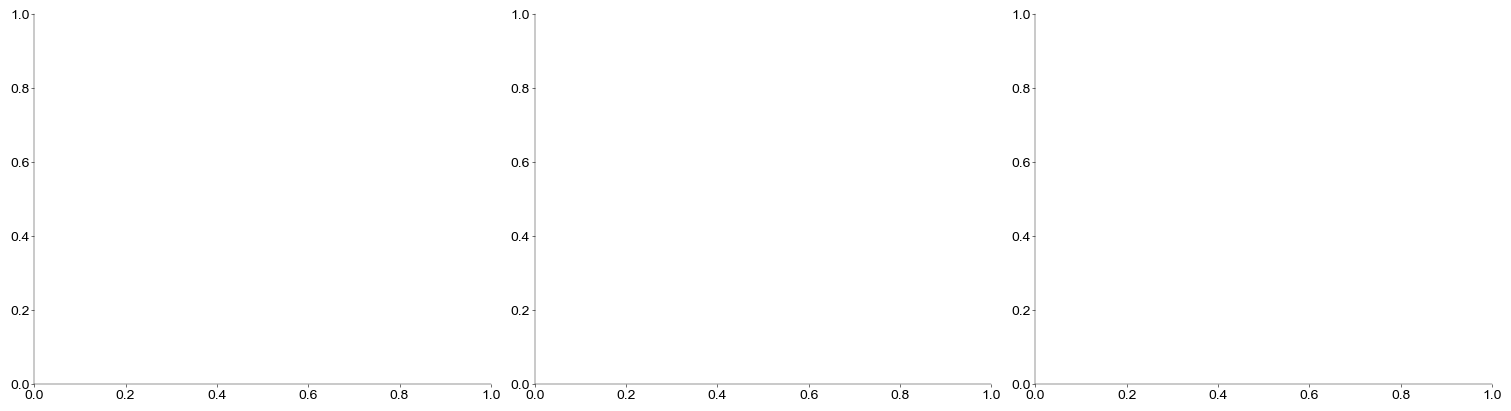

In [389]:
mosaic = "ABC"

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15,4))
# --------------------------------------
# Plot the cell's responses (0.5 points)
# --------------------------------------

# plot the stimulus grid only for one frame

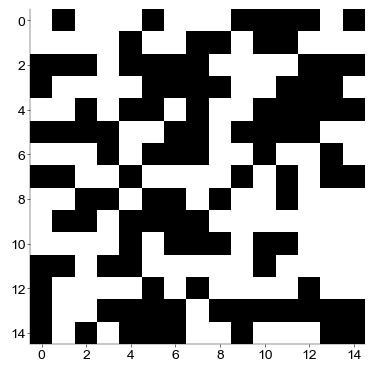

In [391]:
plt.imshow(s[:, 0].reshape((D, D)), cmap='gray')

### Implementation 

Before you run your optimizer, make sure the gradient is correct. The helper function `check_grad` in `scipy.optimize` can help you do that. This package also has suitable functions for optimization. If you generate a large number of  samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

### Calculations
_You can add your calculations in_ $\LaTeX$ _here_.

$L(\omega) = \sum_t \left ( c_t log(r_t) - log(c_t!) - r_t \right ) = \sum_t \left ( c_t \cdot (\omega^Ts_t + log(\Delta t \cdot R)) - log(c_t!) - exp(\omega^T s_t) \cdot \Delta t \cdot R \right )$

$\frac{dL(\omega)}{d\omega} = \sum_t c_t s_{t} - s_t exp(\omega^T s_t) \cdot \Delta t \cdot R  = \sum_t s_t (c_t - r_t)$,

where $s_t$ is a vector of stimulus and $c_t$ and $r_t$ are constants in a given time frame $t$.

In [427]:
from scipy.special import factorial, gammaln

In [496]:
def negloglike_lnp(w, c, s, dt=0.1, R=50, verbose=False):
    '''Implements the negative (!) log-likelihood of the LNP model and its
    gradient with respect to the receptive field w.

    Parameters
    ----------

    x: np.array, (Dx * Dy, )
      current receptive field 

    c: np.array, (nT, )
      spike counts 

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at x
    
    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to x 
    '''
        # insert your code here 

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # and its gradient with respect to the receptive
    # field `w` using the simplified equantions you
    # calculated earlier. (0.5 pts)
    # ------------------------------------------------
    
    r = (np.exp(w[np.newaxis, :] @ s) * R * dt).flatten()
    if verbose:
        print("r.shape = ", r.shape)
        print("c.shape = ", c.shape)
        print("Sum of r: ", r.sum())
        print("c max: ", c.max())
        print("log factorial(c): ", gammaln(c + 1)[:10])
        print("log factorial at c max: ", gammaln(np.max(c) + 1))
    f = np.nansum(-(c * np.log(r) - gammaln(c + 1) - r))

    # using numpy broadcasting each row of s is multiplied by different (c - r)
    df = (-s @ (c - r)[:, np.newaxis]).flatten()
    # flattening is done since singleton dimensions are introduced by making row and column vectors
    
    return f, df


In [476]:
(np.exp(w.flatten()[np.newaxis, :] @ s_ideal) * R * dt)

array([[17.4928064, 17.4928064, 17.4928064, 17.4928064, 17.4928064,
        17.4928064, 17.4928064, 17.4928064, 17.4928064, 17.4928064]])

r.shape =  (10,)
c.shape =  (10,)
Sum of r:  51.15087384378527
c max:  17.5
log factorial(c):  [34.94331578 34.94331578 34.94331578 34.94331578 34.94331578 34.94331578
 34.94331578 34.94331578 34.94331578 34.94331578]
log factorial at c max:  34.943315776876815


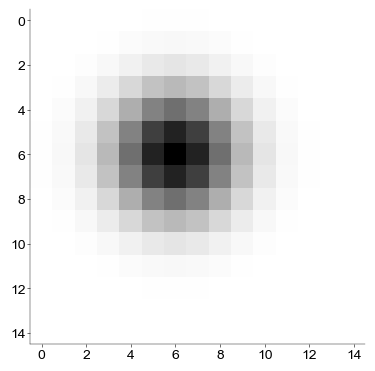

f: 1.1e+02, df norm: 1.9e+01
f: 3.1e+01, df norm: 5.1e+02


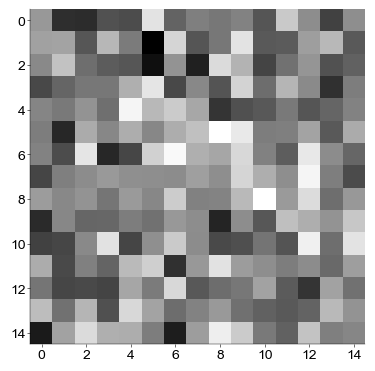

In [521]:
D = 15     # number of pixels
nT = 10  # number of time bins
dt = 0.1   # bins of 100 ms
R = 50     # firing rate in Hz 
v = 5      # stimulus variance

w = gen_gauss_rf(D,7,(1,1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, v)
s_ideal = np.tile(w[:, np.newaxis], nT).reshape(len(w), nT)

f, df = negloglike_lnp(w, np.ones(nT) * 17.5, s_ideal, verbose=True)
plt.imshow(df.reshape((D, D)), cmap='gray')
plt.show()
print(f"f: {f:.1e}, df norm: {np.sqrt(np.sum(df ** 2)):.1e}")
f, df = negloglike_lnp(w, np.ones(nT) * 17.5, s)
print(f"f: {f:.1e}, df norm: {np.sqrt(np.sum(df ** 2)):.1e}")
plt.imshow(df.reshape((D, D)), cmap='gray')

Fit receptive field maximizing the log likelihood

In [523]:
%%time
# insert your code here 

# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly, 
# minimizing the negative log-likelihood).
# 
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------

def estimate_receptive_field(w0, counts, stim, dt=0.1, R=50, verbose=False, **optimizer_params):
    func = lambda w: negloglike_lnp(w, counts, stim, dt, R, False)[0]
    grad = lambda w: negloglike_lnp(w, counts, stim, dt, R, False)[1]
    # check gradient
    grad_error = opt.check_grad(func, grad, w0)
    if verbose:
        f, df = negloglike_lnp(w0, counts, stim, dt, R, True)
        print(f"f(w0) = {f:.1e}")
        print(f" || df(w0) ||_1 = {np.sum(np.abs(df)):.1e}")
        print(f"Gradient estimation error at w0 is {grad_error:.2e}")
    
    # find optimal w by minimazing nll
    res = opt.minimize(func, w0, jac=grad, **optimizer_params)
    return res.x

nT = 100
w = gen_gauss_rf(D, 7, (1, 1))
c, r, s = sample_lnp(w.flatten(), nT, dt, R, v)

w0 = gen_gauss_rf(D,7,(1, 1)).flatten()
w_hat = estimate_receptive_field(w0, c, s, method='BFGS', verbose=True)


r.shape =  (100,)
c.shape =  (100,)
Sum of r:  1603.147177856547
c max:  31
log factorial(c):  [22.55216385 36.39544521 45.3801389  33.50507345 15.10441257 25.19122118
 30.67186011 33.50507345  8.52516136 19.9872145 ]
log factorial at c max:  78.0922235533153
f(w0) = 2.9e+02
 || df(w0) ||_1 = 1.2e+04
Gradient estimation error at w0 is 5.26e-04
CPU times: total: 781 ms
Wall time: 338 ms


seed  1685110860
r.shape =  (500,)
c.shape =  (500,)
Sum of r:  4129.369549369719
c max:  17
log factorial(c):  [17.50230785 15.10441257  3.17805383 17.50230785  4.78749174 33.50507345
 12.80182748 17.50230785  0.         33.50507345]
log factorial at c max:  33.50507345013689
f(w0) = 1.2e+03
 || df(w0) ||_1 = 6.2e+03
Gradient estimation error at w0 is 2.58e-04
r.shape =  (1000,)
c.shape =  (1000,)
Sum of r:  8275.842717243228
c max:  25
log factorial(c):  [33.50507345 10.6046029   6.57925121 36.39544521 15.10441257  8.52516136
 12.80182748 10.6046029  10.6046029  17.50230785]
log factorial at c max:  58.00360522298052
f(w0) = 2.5e+03
 || df(w0) ||_1 = 1.0e+04
Gradient estimation error at w0 is 5.10e-04
r.shape =  (5000,)
c.shape =  (5000,)
Sum of r:  41386.78356395522
c max:  22
log factorial(c):  [ 6.57925121 12.80182748 10.6046029  17.50230785 10.6046029  17.50230785
  3.17805383 15.10441257 15.10441257 10.6046029 ]
log factorial at c max:  48.47118135183523
f(w0) = 1.2e+04
 || df(w

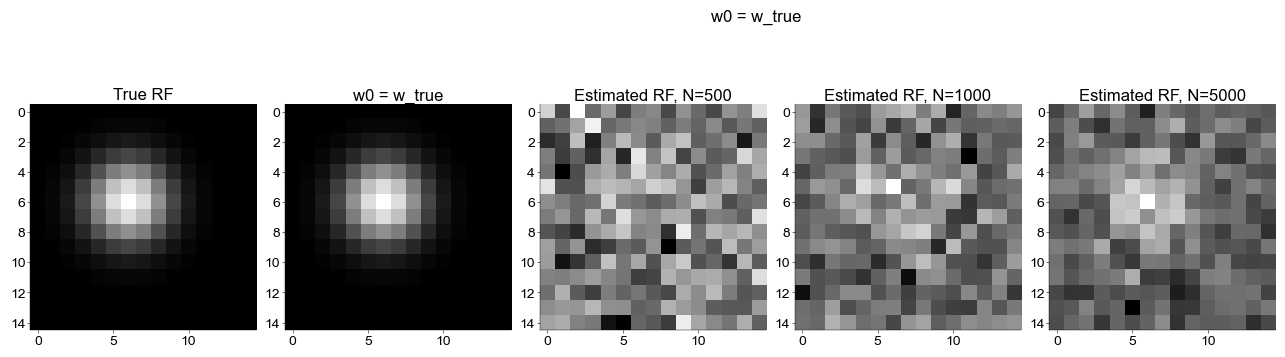

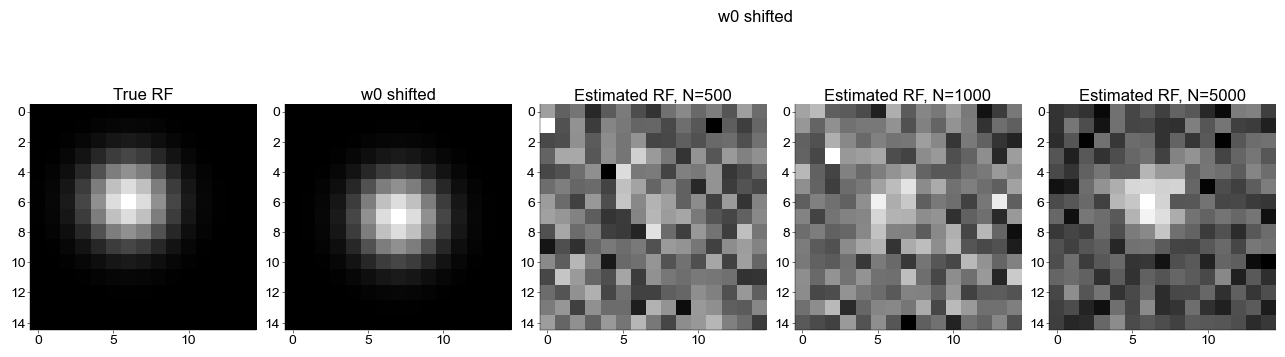

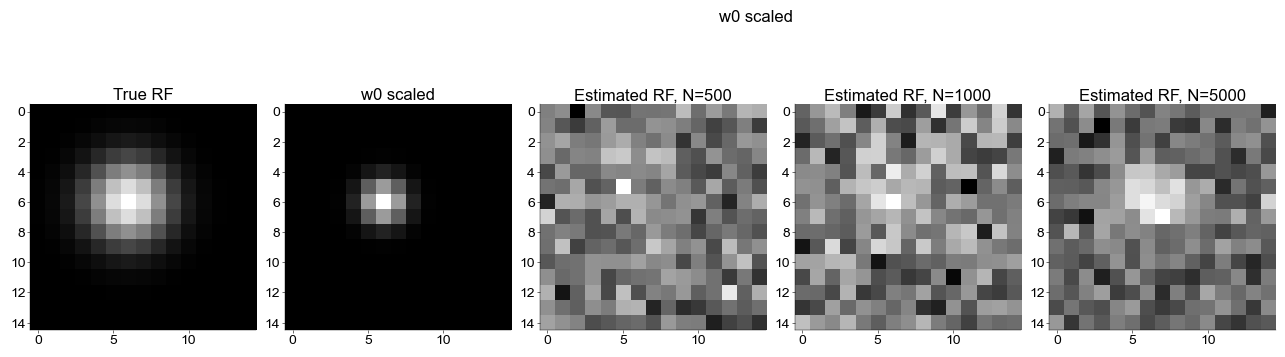

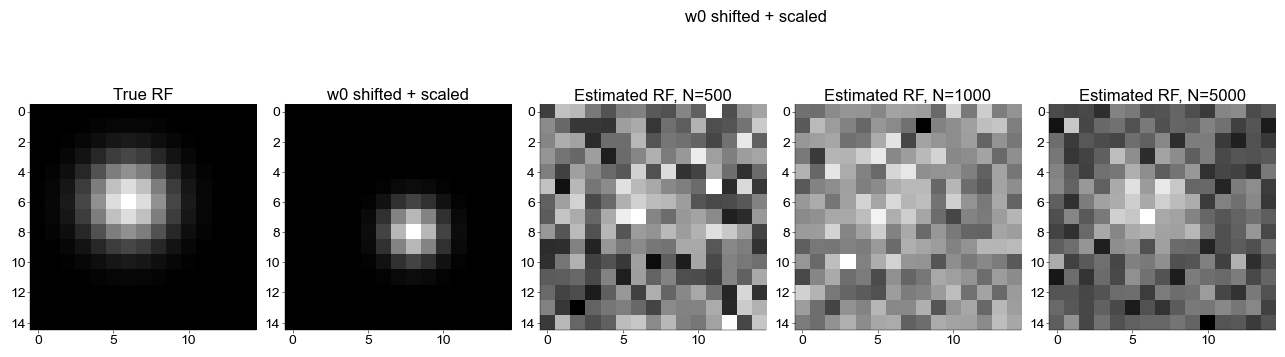

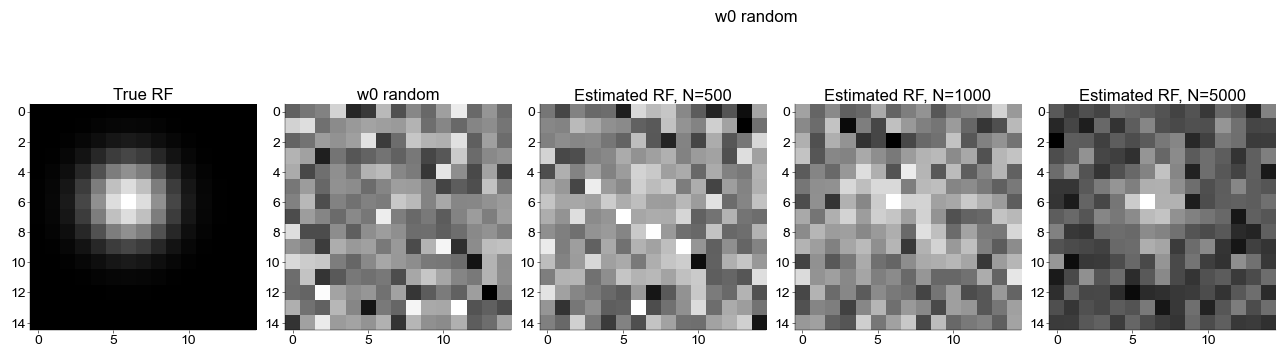

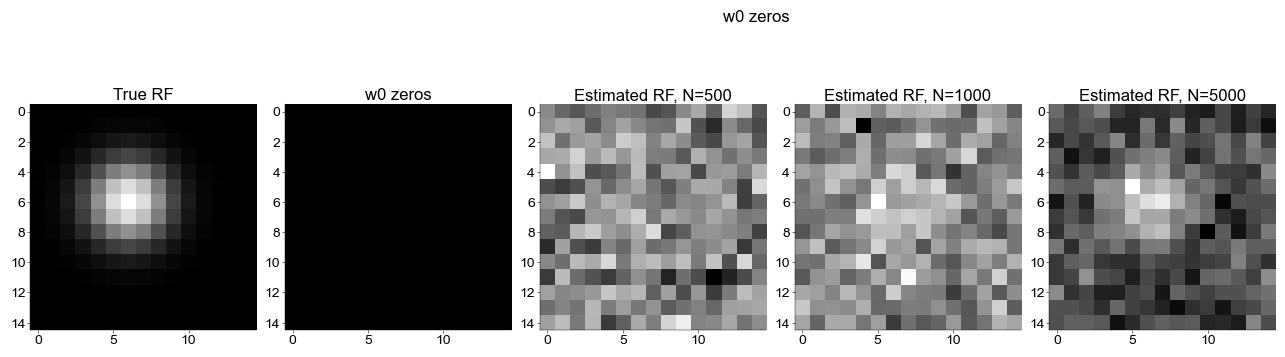

In [524]:
%%time
seed = int(time.time())
np.random.seed(seed)
print("seed ", seed)

# np.random.seed(42)

# different intializations
w0_labels = ["w0 = w_true", 
             "w0 shifted", 
             "w0 scaled", 
             "w0 shifted + scaled", 
             "w0 random", 
             "w0 zeros"]

w_true = gen_gauss_rf(D, 7, (1, 1)).flatten()
nT = 100
dt = 0.1
R = 50
v = 1

w0_list = [gen_gauss_rf(D, 7, (1, 1)).flatten(), 
           gen_gauss_rf(D, 7, (0, 0)).flatten(), 
           gen_gauss_rf(D, 2, (1, 1)).flatten(), 
           gen_gauss_rf(D, 3, (-1, -1)).flatten(), 
           stats.norm.rvs(size=(D, D)).flatten(), 
           np.zeros(D * D)]

for w0, w0_label in zip(w0_list, w0_labels):
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, len(w0_list), 1)
    plt.imshow(w_true.reshape((D, D)), cmap='gray')
    plt.title(f"True RF")
    
    plt.subplot(1, len(w0_list), 2)
    plt.imshow(w0.reshape((D, D)), cmap='gray')
    plt.title(w0_label)
    
    for i, nT in enumerate([500, 1000, 5000]):

        c, r, s = sample_lnp(w_true.flatten(), nT, dt, R, v)
        w_hat = estimate_receptive_field(w0, c, s, method="L-BFGS-B", verbose=True)

        plt.subplot(1, len(w0_list), i + 3)
        plt.imshow(w_hat.reshape((D, D)), cmap='gray')
        plt.title(f"Estimated RF, N={nT}")
       
    plt.suptitle(w0_label)

In [ ]:
%%time
import warnings
warnings.filterwarnings("ignore")

w0 = w0_list[-1]

plt.figure(figsize=(15, 4))

plt.subplot(1, 5, 1)
plt.imshow(w.reshape((D, D)), cmap='gray')
plt.title(f"True RF")

plt.subplot(1, 5, 2)
plt.imshow(w0.reshape((D, D)), cmap='gray')
plt.title(w0_labels[-1])

for i, nT in enumerate([1000, 10000, 50000]):

    c, r, s = sample_lnp(w.flatten(), nT, dt, R, v)
    w_hat = estimate_receptive_field(w0, c, s, method='L-BFGS-B')

    plt.subplot(1, 5, i + 3)
    plt.imshow(w_hat.reshape((D, D)), cmap='gray')
    plt.title(f"Estimated RF, N={nT}")

plt.suptitle(w0_label)

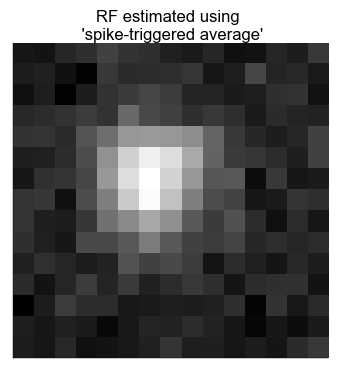

In [453]:
c, r, s = sample_lnp(w.flatten(), 100000, dt, R, v)

# let's try the simplest approach to approximate RF: spike-triggered average.
# In our case let's weight the stimuli by the corresponding spike counts and average them

w_sta = s @ c[:, np.newaxis] / len(c)
plt.title("RF estimated using \n 'spike-triggered average'")
plt.imshow(w_sta.reshape((D, D)), cmap='gray')
plt.xticks([])
plt.yticks([]);

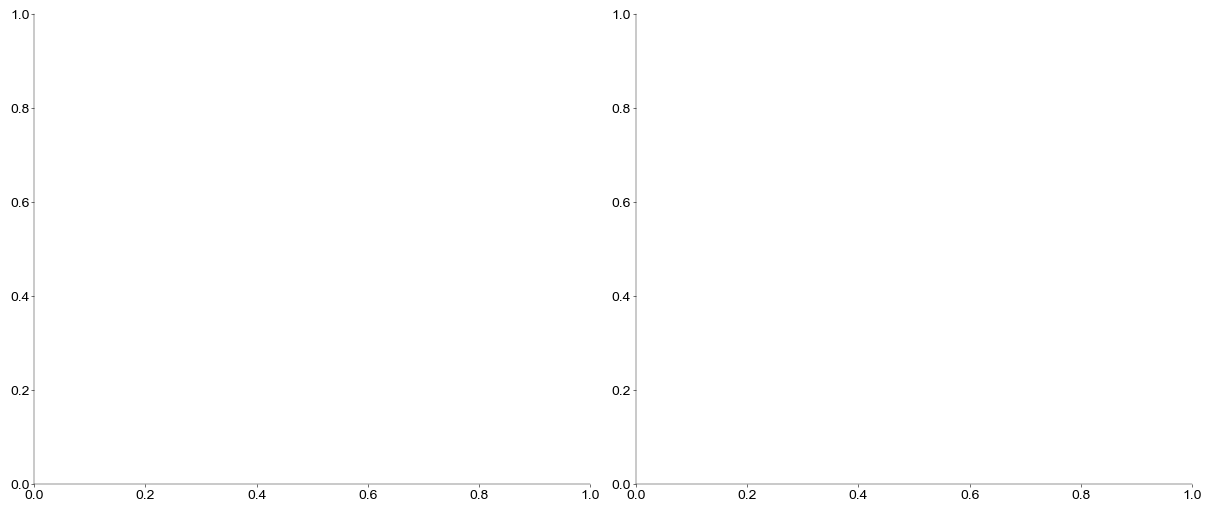

In [365]:
# insert your code here 

# ------------------------------------
# Plot the ground truth and estimated 
# `w` side by side. (0.5 pts)
# ------------------------------------

mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12,5))

# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.

## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 2 pts*


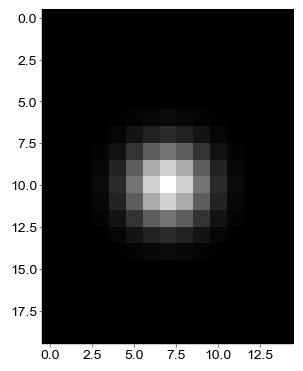

In [454]:
# For smart initialization
def gen_gauss_rf_varsize(Dx, Dy, width, center=(0,0)):
    """ The function is stupid assuming x is odd and y is even."""
    szx, szy = Dx // 2, Dy // 2
    x, y = np.meshgrid(np.arange(-szx, szx + 1), np.arange(-szy, szy))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(- (x ** 2/width + y ** 2 / width))
    w = w / np.sum(w.flatten())
    
    return w

w = gen_gauss_rf_varsize(15, 20, 5)
w.shape
plt.imshow(w, cmap='gray')

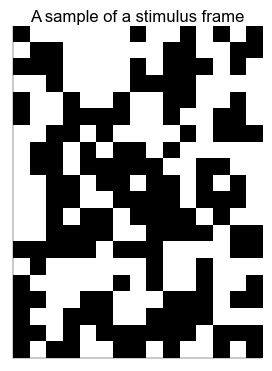

In [455]:
var = io.loadmat('../data/nds_cl_5_data.mat')

# t contains the spike times of the neuron
t = var['DN_spiketimes'].flatten()    

# trigger contains the times at which the stimulus flipped
trigger = var['DN_triggertimes'].flatten()

# contains the stimulus movie with black and white pixels
s = var['DN_stim']
s = s.reshape((300, 1500)) # the shape of each frame is (20, 15)
stim = s[:, 1:len(trigger)]

_, nT = s.shape

plt.imshow(s[:, 0].reshape(frame_size), cmap='gray');
plt.title("A sample of a stimulus frame")
plt.xticks([])
plt.yticks([]);

Stimulus shape:  (300, 1500)
Trggers shape:  (5500,)
Counts shape:  (1488,)
Estimated time step size dt = 1.00
Estimated mean firing rate R = 17.1


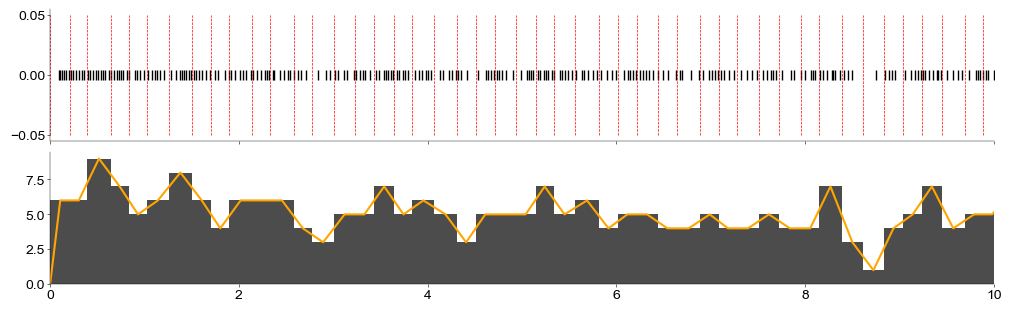

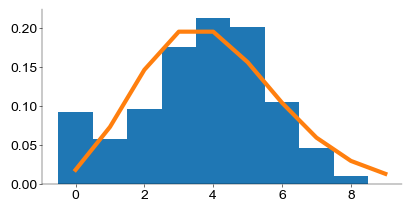

In [457]:
print("Stimulus shape: ", s.shape)
print("Trggers shape: ", t.shape)

fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

ax = axes[0]
ax.vlines(trigger, -0.05, 0.05, color='red', linewidth=0.5, linestyle='--')
ax.scatter(t, np.zeros(len(t)), s=50, marker='|', facecolor='black')

# bin the spikes
bin_indices = np.arange(len(trigger))
bins = np.append(trigger, t.max() + .1) # include the righmost boundary since the last change of the stimulus
bin_centers = np.convolve(bins, np.ones(2) / 2, 'same')
t_digit = np.digitize(t, bins)
counts = np.bincount(t_digit)

ax = axes[1]
ax.hist(t, bins, color='black', alpha=0.7)
ax.plot(bin_centers, counts, color='orange', linewidth=1.5)
ax.set_xlim((0, 10))

counts = counts[1:len(trigger)] # slicing to align with the stim of shape (300, 1488)
print("Counts shape: ", counts.shape)

plt.figure(figsize=(4, 2))
bins = np.arange(10)
plt.hist(counts, bins=np.arange(10) - 0.5, density=True)
plt.plot(stats.poisson(mu=4).pmf(bins), linewidth=3);

dt = np.diff(bins[:-2]).mean() # estimating dt as a mean time interval between frames
R = len(t) / t[-1]
print(f"Estimated time step size dt = {dt:.2f}")
print(f"Estimated mean firing rate R = {R:.1f}")

Create vector of spike counts

In [335]:
# insert your code here 

# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------

In [465]:
a = np.arange(5) / 1.1
a[3] = np.nan

np.nansum(a)

6.363636363636363

Fit receptive field for each frame separately

In [474]:
%%time
# insert your code here 

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
# 
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------
np.random.seed(42)

frame_size = (20, 15)
n_augment = 1 # just a parameter to repeat the array of observations a set number of times
# set as 1 to keep the original s and counts array sizes

# specify the time lags
delta_list = [0, 1, 2, 3, 4]

w_hat = np.zeros((np.prod(frame_size), len(delta_list)))
# initializing w0 as a gaussian RF
w0 = gen_gauss_rf_varsize(15, 20, 7).flatten()
# initializing w0 as a random vector
#w0 = stats.norm.rvs(size=frame_size).flatten()
w0 = np.zeros(frame_size).flatten()

c = np.tile(counts, n_augment)
s = np.tile(stim, (1, n_augment))


# fit for each delay
for delta in delta_list:
    np.random.seed(delta)
    #w0 = stats.norm.rvs(size=frame_size).flatten()
    w_hat[:, delta] = estimate_receptive_field(w0, c[delta:], s[:, :len(c) - delta], dt, , method="L-BFGS-B", verbose=True)
    
print("Shape of the output RF estimate tensor: ", w_hat.shape)

r.shape =  (1488,)
c.shape =  (1488,)
Sum of r:  1488.0
c max:  9
log factorial(c):  [ 6.57925121  6.57925121 12.80182748 ...  0.          0.
  0.        ]
f(w0) = 6.3e+03
 || df(w0) ||_1 = 1.5e+08
Gradient estimation error at w0 is 8.91e+06
r.shape =  (1487,)
c.shape =  (1487,)
Sum of r:  1487.0
c max:  9
log factorial(c):  [ 6.57925121 12.80182748  8.52516136 ...  0.          0.
  0.        ]
f(w0) = 6.3e+03
 || df(w0) ||_1 = 1.5e+08
Gradient estimation error at w0 is 8.94e+06
r.shape =  (1486,)
c.shape =  (1486,)
Sum of r:  1486.0
c max:  9
log factorial(c):  [12.80182748  8.52516136  4.78749174 ...  0.          0.
  0.        ]
f(w0) = 6.3e+03
 || df(w0) ||_1 = 1.5e+08
Gradient estimation error at w0 is 8.90e+06
r.shape =  (1485,)
c.shape =  (1485,)
Sum of r:  1485.0
c max:  9
log factorial(c):  [8.52516136 4.78749174 6.57925121 ... 0.         0.         0.        ]
f(w0) = 6.3e+03
 || df(w0) ||_1 = 1.5e+08
Gradient estimation error at w0 is 8.84e+06
r.shape =  (1484,)
c.shape =  (

<BarContainer object of 1488 artists>

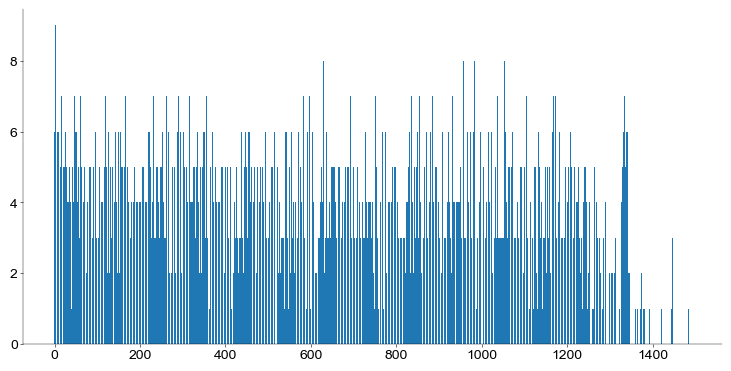

In [379]:
plt.bar(np.arange(len(c)), c)

Plot the frames one by one

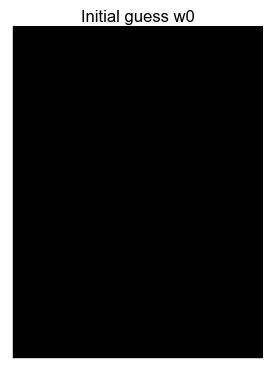

In [371]:
plt.title("Initial guess w0")
plt.imshow(w0.reshape(frame_size), cmap='gray')
plt.xticks([])
plt.yticks([]);

In [380]:
w_hat.shape

(300, 5)

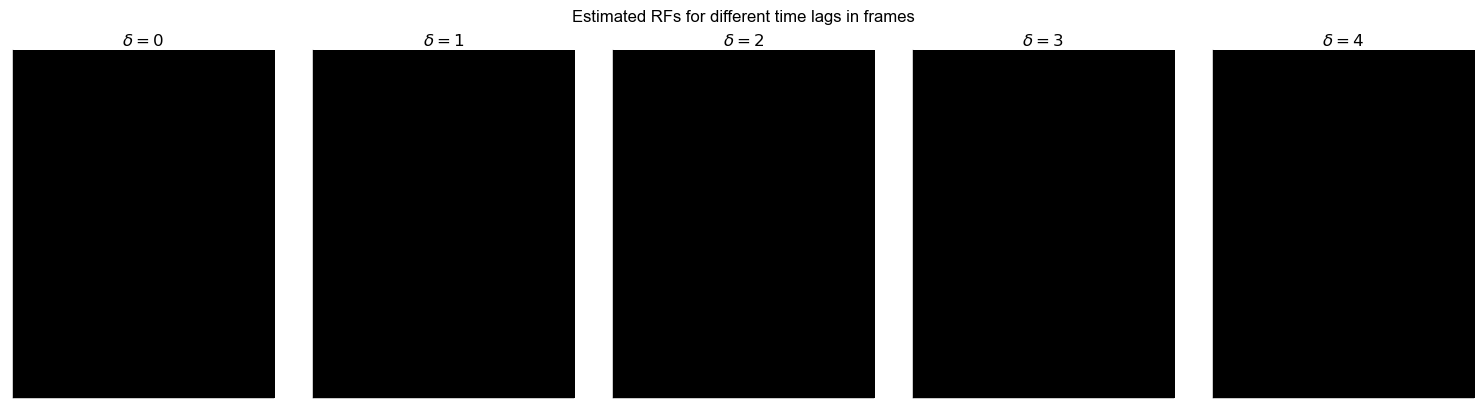

In [470]:
fig, axes = plt.subplots(1, len(delta_list), figsize=(15, 4))

plt.suptitle("Estimated RFs for different time lags in frames")

for delta in delta_list:
    ax = axes[delta]
    ax.set_title(f"$\delta={{{delta}}}$")
    ax.imshow(w_hat[:, delta].reshape(frame_size), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([]);

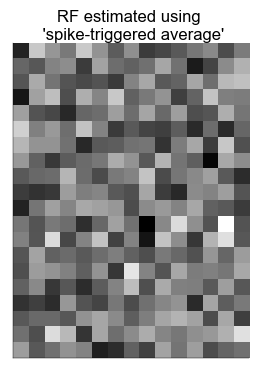

In [339]:
# let's try the simplest approach to approximate RF: spike-triggered average.
# In our case let's weight the stimuli by the corresponding spike counts and average them

for delta in delta_list:
    w_sta = s[:, :len(c) - delta] @ c[delta:, np.newaxis] / len(c)
    plt.subplot(1, len(delta_list), delta + 1)
    plt.title(f"RF estimated using \n 'spike-triggered average' \n delta = {delta}")
    plt.imshow(w_sta.reshape(frame_size), cmap='gray')
    plt.xticks([])
    plt.yticks([]);

In [350]:
f, df = negloglike_lnp(gen_gauss_rf_varsize(15, 20, 7).flatten(), c, s, dt, R)
print(f"f: {f:.1f}, df norm: {np.sqrt(np.sum(df ** 2)):.1f}")

f: 142915.2, df norm: 405582640.5


In [ ]:
# insert your code here 

# --------------------------------------------
# Plot all 5 frames of the fitted RFs (0.5 pt)
# --------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10,4), constrained_layout=True)


## Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1 pts*

In [ ]:
# insert your code here 

# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------

# shape of w_hat: (300,5). 
# subtract mean along axis=1 (time) since for every timelag the RF is estimated independently

# -------------------------------------------------
# Plot the spatial and temporal components (0.5 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[['Spatial', 'Temporal']], figsize=(10,4), constrained_layout=True)
# add plot


## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 2 pts*


In [14]:
from sklearn import linear_model

# insert your code here 

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before) 
# with sklern or pyglmnet (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]


In [ ]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10,4), constrained_layout=True)
# add plot